In [1]:
import zarr
import dask.array as da
import nibabel as nib
import numpy as np
import pandas as pd
from scipy.interpolate import interpn
from dask.diagnostics import ProgressBar
from ome_zarr.writer import write_labels, write_label_metadata
from ome_zarr.scale import Scaler

/tmp/ipykernel_893162/3919010988.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
"""
in_zarr=snakemake.input.zarr_zip
in_xfm=snakemake.input.xfm_ras
in_template_dseg=snakemake.input.dseg
out_zarr=snakemake.output.zarr
level=snakemake.params.level_to_resample_to
max_layer=snakemake.params.max_downsampling_layers #number of downsamplings by 2 to include in zarr
label_tsv = snakemake.input.label_tsv
scaling_method=snakemake.params.scaling_method
label_name=snakemake.params.label_name
"""

in_zarr='/home/ROBARTS/alik/graham/cfmm-bids/Prado/LightsheetMicroscopy/bids_spimprep_20240223/sub-mouse1/micr/sub-mouse1_sample-brain_acq-1x_spim.ome.zarr.zip'
in_xfm='results/sub-mouse1/warps/sub-mouse1_sample-brain_acq-1x_from-subject_to-ABAv3_type-ras_desc-affine_xfm.txt'
level=0
in_template_dseg='results/tpl-ABAv3/tpl-ABAv3_dseg.nii.gz'
in_flo_nii='results/sub-mouse1/micr/sub-mouse1_sample-brain_acq-1x_stain-autof_level-4_spim.nii'
out_zarr='results/sub-mouse1/warps/test_warped_to_template.zarr'

#load dask array from zarr reference image, grabbing first channel (any channel will do)
darr = da.from_zarr(in_zarr,component=f'/{level}')[0,:,:,:].squeeze()

#load template dseg (this will be ref space for now)
dseg_nib = nib.load(in_template_dseg)

# get dseg volume for interpolation,
dseg_vol = dseg_nib.get_fdata()
dseg_darr = da.from_array(dseg_vol)

flo_nib = nib.load(in_flo_nii)



"""
# along with grid points for interpolation
grid_points = (np.arange(dseg_vol.shape[0]),
             np.arange(dseg_vol.shape[1]),
             np.arange(dseg_vol.shape[2]))
"""


#read coordinate transform from ome-zarr
zi = zarr.open(in_zarr)
attrs=zi['/'].attrs.asdict()
multiscale=0 #first multiscale image
transforms = attrs['multiscales'][multiscale]['datasets'][level]['coordinateTransformations']

#for writing metadata:
#axes = attrs['multiscales'][multiscale]['axes'][-3:] #only grab the spatial axes
#coordinate_transformations = [ attrs['multiscales'][multiscale]['datasets'][level]['coordinateTransformations'] for level in range(level,max_layer+1)]

#only grab the spatial axes for scale transforms too:
#for level_i in range(len(coordinate_transformations)):
#    for t in range(len(coordinate_transformations[level_i])):
#        coordinate_transformations[level_i][t]['scale'] = coordinate_transformations[level_i][t]['scale'][-3:]

#need to put together the sequence of transforms to apply

In [3]:
dseg_darr

dask.array<array, shape=(456, 528, 320), dtype=float64, chunksize=(255, 255, 255), chunktype=numpy.ndarray>

In [4]:
# 1. scaling_xfm (vox2ras in spim space)
#note: zarr uses z,y,x ordering, we reverse this for nifti; also the negation to flip
# this matches what the ome_zarr_to_nii affine has
reorder_xfm = np.eye(4)
reorder_xfm[:3,:3] = np.flip(np.eye(3),axis=0) #reorders z-y-x to x-y-z and vice versa

scaling_xfm = np.eye(4)
scaling_xfm[0,0]=-transforms[0]['scale'][-1] #x  # 0-index in transforms is the first (and only) transform 
scaling_xfm[1,1]=-transforms[0]['scale'][-2] #y
scaling_xfm[2,2]=-transforms[0]['scale'][-3] #z

# 2. affine_inv_xfm (from registration, takes points from spim ras to template ras)
affine_inv_xfm = np.linalg.inv(np.loadtxt(in_xfm))



# 3. ras2vox in template space
ras2vox = np.linalg.inv(dseg_nib.affine)

# concatenate all three
concat_xfm_spim_to_template = ras2vox @ affine_inv_xfm @ scaling_xfm 
concat_xfm_template_to_spim = np.linalg.inv(concat_xfm_spim_to_template)

In [27]:
scaling_xfm

array([[-0.00270833,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.00270833,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.1       ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [28]:
reorder_xfm 

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [29]:
concat_xfm_spim_to_template

array([[-1.97255324e-02, -9.66591310e-03, -1.02044791e-01,
         5.07692352e+02],
       [ 1.96872469e-01, -9.83677222e-02,  1.19010840e-02,
         5.44795088e+02],
       [-4.40723967e+00, -2.39222753e-03,  1.03070891e-03,
         3.15803775e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [30]:
concat_xfm_template_to_spim

array([[-1.62771752e-03,  5.67162508e-03, -2.26638753e-01,
         6.93098802e+01],
       [-1.17536324e+00, -1.00396629e+01, -4.43213600e-01,
         6.20625050e+03],
       [-9.68797057e+00,  9.49883208e-01,  8.57920734e-02,
         4.37392340e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [5]:
def interp_img(x,block_info=None):

    #main idea here is we take coordinates from the current block (ref image)
    #transform them, then in that transformed space, interpolate the 
    #floating image intensities

    #since the floating image is a dask array, we need to just load a 
    #subset of it -- we use the bounds of the points in the transformed 
    # space to define what range of the floating image we load in
    
    
    arr_location = block_info[0]['array-location']
        
    xv,yv,zv=np.meshgrid(np.arange(arr_location[2][0],arr_location[2][1]),
            np.arange(arr_location[1][0],arr_location[1][1]),
            np.arange(arr_location[0][0],arr_location[0][1]))
    
    
    #reshape them into a vectors (x,y,z,1) for each point, so we can matrix multiply
    xvf=xv.reshape((1,np.product(xv.shape)))
    yvf=yv.reshape((1,np.product(yv.shape)))
    zvf=zv.reshape((1,np.product(zv.shape)))
    homog=np.ones(xvf.shape)
    
    vecs=np.vstack((xvf,yvf,zvf,homog))
    
    xfm_vecs =  concat_xfm_template_to_spim @ vecs
    
    
    min_extent=xfm_vecs.min(axis=1)[:3]
    max_extent=xfm_vecs.max(axis=1)[:3]
    
    min_extent=np.floor(np.maximum(min_extent,np.zeros(min_extent.shape)))
    max_extent=np.ceil(np.minimum(max_extent,(darr.shape[-1],darr.shape[-2],darr.shape[-3])))
    
    
    
    #get this part of the floating image darr
    flo_vol = np.moveaxis(darr[min_extent[2]:max_extent[2],
            min_extent[1]:max_extent[1],
            min_extent[0]:max_extent[0]].compute(),(0,1,2),(2,1,0))
    
        
    # along with grid points for interpolation
    grid_points = (np.arange(max_extent[0]-min_extent[0]),
                   np.arange(max_extent[1]-min_extent[1]),
                   np.arange(max_extent[2]-min_extent[2]))
               
    
    #shift  xfm_vecs by the min_extent
    xfm_vecs_offset = xfm_vecs-np.tile(np.array((min_extent[0],min_extent[1],min_extent[2],0)),(xfm_vecs.shape[1],1)).T
    
    
    #then finally interpolate those points on the template dseg volume
    interpolated = interpn(grid_points,flo_vol,
                        xfm_vecs_offset[:3,:].T, #
                        method='nearest',
                        bounds_error=False,
                        fill_value=0)
    
    return interpolated.reshape(x.shape)

In [68]:
#arr_location=((0,dseg_vol.shape[2]),(0,dseg_vol.shape[1]),(0,dseg_vol.shape[0]))
arr_location=((0,255),(0,255),(0,255))



xv,yv,zv=np.meshgrid(np.arange(arr_location[2][0],arr_location[2][1]),
        np.arange(arr_location[1][0],arr_location[1][1]),
        np.arange(arr_location[0][0],arr_location[0][1]))


#reshape them into a vectors (x,y,z,1) for each point, so we can matrix multiply
xvf=xv.reshape((1,np.product(xv.shape)))
yvf=yv.reshape((1,np.product(yv.shape)))
zvf=zv.reshape((1,np.product(zv.shape)))
homog=np.ones(xvf.shape)

vecs=np.vstack((xvf,yvf,zvf,homog))

xfm_vecs =  concat_xfm_template_to_spim @ vecs

min_extent=vecs.min(axis=1)[:3]
max_extent=vecs.max(axis=1)[:3]

print(min_extent)
print(max_extent)


min_extent=xfm_vecs.min(axis=1)[:3]
max_extent=xfm_vecs.max(axis=1)[:3]

print(min_extent)
print(max_extent)

min_extent=np.floor(np.maximum(min_extent,np.zeros(min_extent.shape)))
max_extent=np.ceil(np.minimum(max_extent,(darr.shape[-1],darr.shape[-2],darr.shape[-3])))


print(min_extent)
print(max_extent)

#get this part of the floating image darr
flo_vol = np.moveaxis(darr[min_extent[2]:max_extent[2],
        min_extent[1]:max_extent[1],
        min_extent[0]:max_extent[0]].compute(),(0,1,2),(2,1,0))



# along with grid points for interpolation
grid_points = (np.arange(max_extent[0]-min_extent[0]),
               np.arange(max_extent[1]-min_extent[1]),
               np.arange(max_extent[2]-min_extent[2]))
               

#shift  xfm_vecs by the min_extent
xfm_vecs_offset = xfm_vecs-np.tile(np.array((min_extent[0],min_extent[1],min_extent[2],0)),(xfm_vecs.shape[1],1)).T

min_extent_offset=xfm_vecs_offset.min(axis=1)[:3]
max_extent_offset=xfm_vecs_offset.max(axis=1)[:3]
print(min_extent_offset)
print(max_extent_offset)


#then finally interpolate those points on the template dseg volume
interpolated = interpn(grid_points,flo_vol,
                    xfm_vecs_offset[:3,:].T, #
                    method='nearest',
                    bounds_error=False,
                    fill_value=0)

interpolated_vol = interpolated.reshape((255,255,255))

[0. 0. 0.]
[254. 254. 254.]
[1913.17887209 3245.05759855   11.33019657]
[4636.9849177  6206.2504982    70.75047295]
[1913. 3245.   11.]
[4637. 6207.   67.]
[0.17887209 0.05759855 0.33019657]
[2723.9849177  2961.2504982    59.75047295]


In [56]:
flo_vol.shape

(2724, 2962, 56)

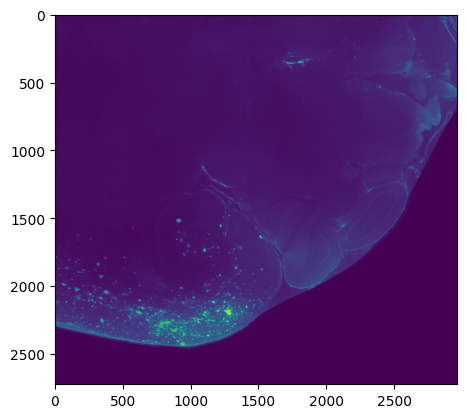

In [57]:
plt.imshow(flo_vol[:,:,30])

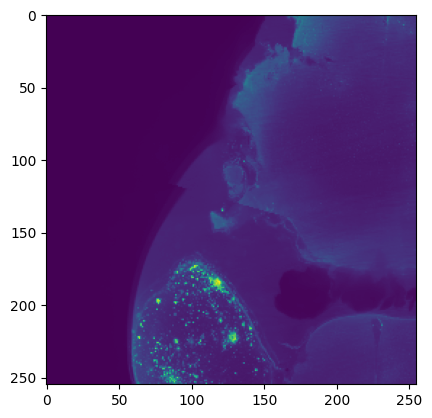

In [62]:
plt.imshow(interpolated_vol[:,:,50])

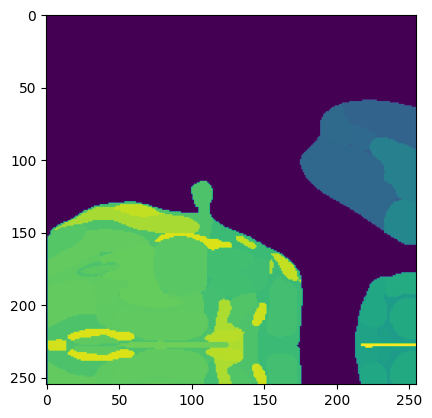

In [63]:
plt.imshow(dseg_vol[:255,:255,50])


In [130]:
grid_points[0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66.])

In [124]:
flo_img.shape

(9, 573, 526)

In [120]:
darr.shape

(67, 7232, 6114)

In [72]:
flo_img.shape

(9, 573, 526)

(4, 125000)
[0. 0. 0.]
[49. 49. 49.]
[3899.21283843 5634.99674985   58.1248231 ]
[4424.67148502 6206.2504982    69.58778981]
[3899. 5634.   58.]
[4425. 6207.   67.]


In [65]:
darr.shape

(67, 7232, 6114)

In [39]:
darr.shape

(67, 7232, 6114)

In [6]:


#perform interpolation on each block of spim zarr, in parallel
darr_map=da.map_blocks(interp_img,dseg_darr, dtype=np.uint16)



In [7]:
with ProgressBar():
    darr_map.to_zarr(out_zarr,overwrite=True)

[########################################] | 100% Completed | 78.10 s


In [8]:
resampled = da.from_zarr(out_zarr)
resampled


dask.array<from-zarr, shape=(456, 528, 320), dtype=uint16, chunksize=(255, 255, 255), chunktype=numpy.ndarray>

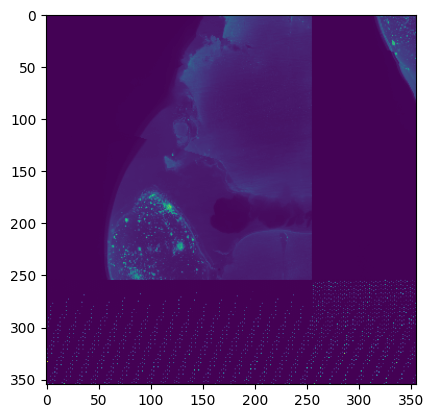

In [12]:
import matplotlib.pyplot as plt
plt.imshow(resampled[:355,:355,50].squeeze())

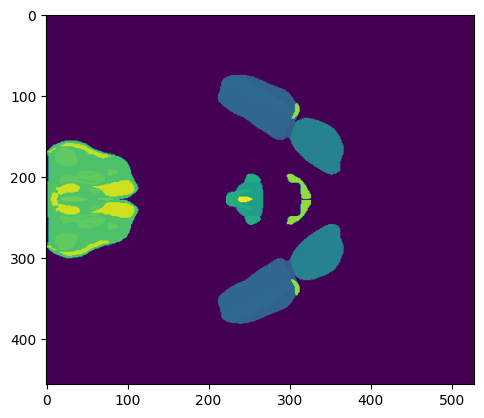

In [46]:
plt.imshow(dseg_vol[:,:,30].squeeze())